In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, confusion_matrix, classification_report)

import joblib
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


In [2]:
df = pd.read_csv('data/diabetes_prediction_dataset.csv')
print('Original shape:', df.shape)
df.head()

Original shape: (100000, 9)


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [4]:
for col in df.columns:
    print(col)
    print(df[col].unique(), '\n')

gender
['Female' 'Male' 'Other'] 

age
[80.   54.   28.   36.   76.   20.   44.   79.   42.   32.   53.   78.
 67.   15.   37.   40.    5.   69.   72.    4.   30.   45.   43.   50.
 41.   26.   34.   73.   77.   66.   29.   60.   38.    3.   57.   74.
 19.   46.   21.   59.   27.   13.   56.    2.    7.   11.    6.   55.
  9.   62.   47.   12.   68.   75.   22.   58.   18.   24.   17.   25.
  0.08 33.   16.   61.   31.    8.   49.   39.   65.   14.   70.    0.56
 48.   51.   71.    0.88 64.   63.   52.    0.16 10.   35.   23.    0.64
  1.16  1.64  0.72  1.88  1.32  0.8   1.24  1.    1.8   0.48  1.56  1.08
  0.24  1.4   0.4   0.32  1.72  1.48] 

hypertension
[0 1] 

heart_disease
[1 0] 

smoking_history
['never' 'No Info' 'current' 'former' 'ever' 'not current'] 

bmi
[25.19 27.32 23.45 ... 59.42 44.39 60.52] 

HbA1c_level
[6.6 5.7 5.  4.8 6.5 6.1 6.  5.8 3.5 6.2 4.  4.5 9.  7.  8.8 8.2 7.5 6.8] 

blood_glucose_level
[140  80 158 155  85 200 145 100 130 160 126 159  90 260 220 300 280 2

In [5]:
len(df[df.gender == 'Other'])

18

In [6]:
df = df[df['gender'] != 'Other'].copy()
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

# Replace 'No Info' with 'unknown' in smoking_history
df['smoking_history'] = df['smoking_history'].replace('No Info', 'unknown')


print('After basic cleaning:', df.shape)
df.head()

After basic cleaning: (99982, 9)


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,never,25.19,6.6,140,0
1,0,54.0,0,0,unknown,27.32,6.6,80,0
2,1,28.0,0,0,never,27.32,5.7,158,0
3,0,36.0,0,0,current,23.45,5.0,155,0
4,1,76.0,1,1,current,20.14,4.8,155,0


In [7]:
numeric_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
categorical_features = ['smoking_history', 'gender', 'hypertension', 'heart_disease']

### EDA

In [8]:
df.describe()

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000
mean,0.414375,41.888076,0.074863,0.039427,27.320757,5.527529,138.057810,0.085015
std,0.492616,22.517206,0.263172,0.194610,6.636853,1.070665,40.709469,0.278906
min,0.000000,0.080000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,0.000000,24.000000,0.000000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,0.000000,43.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,1.000000,60.000000,0.000000,0.000000,29.580000,6.200000,159.000000,0.000000
max,1.000000,80.000000,1.000000,1.000000,95.690000,9.000000,300.000000,1.000000


<Axes: xlabel='diabetes', ylabel='count'>

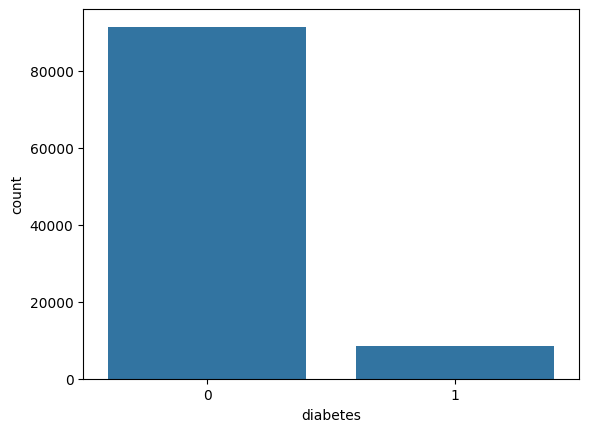

In [9]:
sns.countplot(x='diabetes', data=df)

In [10]:
class_counts = df['diabetes'].value_counts()
class_percentages = df['diabetes'].value_counts(normalize=True) * 100

print("Class distribution:")
print(class_counts)
print("\nClass percentage:")
print(class_percentages)

Class distribution:
diabetes
0    91482
1     8500
Name: count, dtype: int64

Class percentage:
diabetes
0    91.49847
1     8.50153
Name: proportion, dtype: float64


-- Dataset has class imbalance which needs to be dealed with to avoid overfitting to only class 

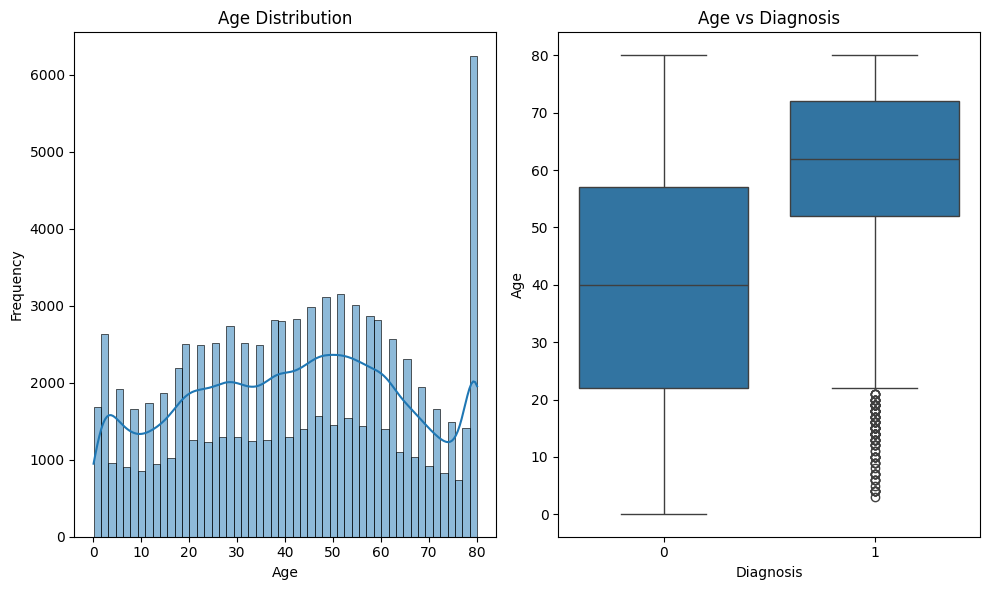

In [11]:
# Age vs Diabetes
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.histplot(df.age, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(x='diabetes', y='age', data=df)
plt.title('Age vs Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('Age')
plt.tight_layout()
plt.show()

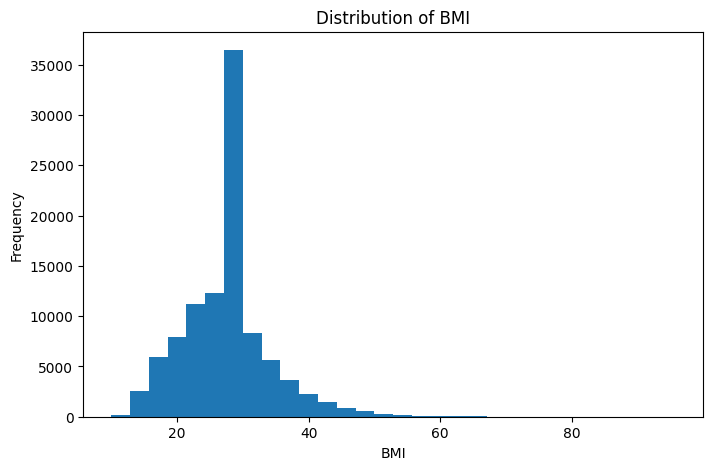

In [12]:
plt.figure(figsize=(8,5))
plt.hist(df["bmi"], bins=30)
plt.xlabel("BMI")
plt.ylabel("Frequency")
plt.title("Distribution of BMI")
plt.show()

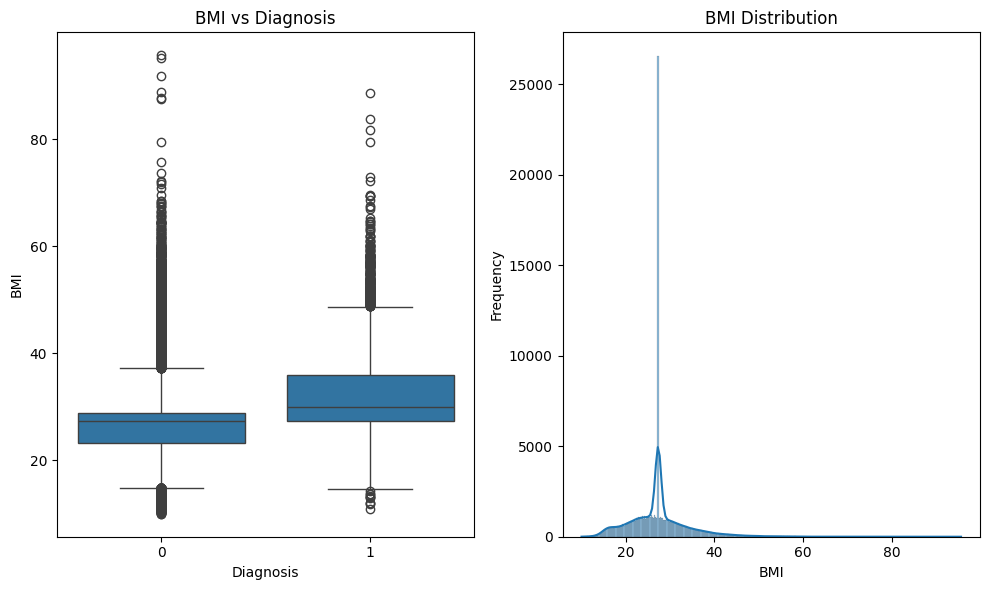

In [13]:
# BMI vs Diabetes
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='diabetes', y='bmi', data=df)
plt.title('BMI vs Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('BMI')

plt.subplot(1, 2, 2)
sns.histplot(df.bmi, kde=True)
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

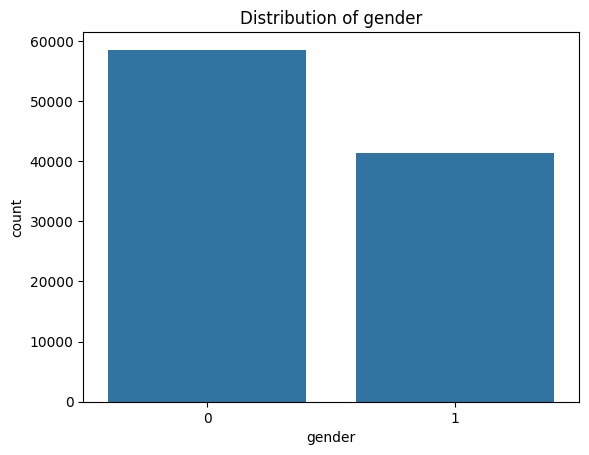

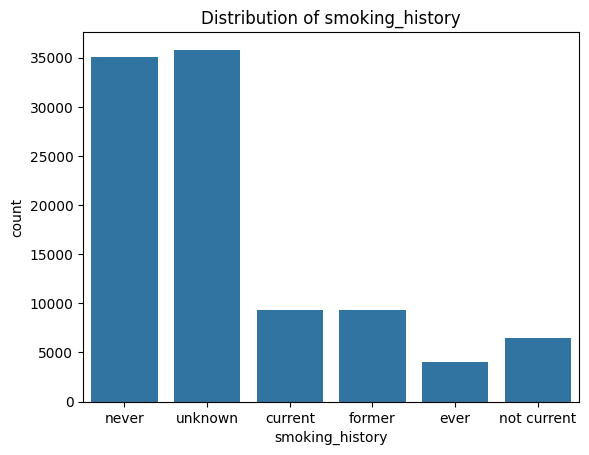

In [14]:
for col in ['gender', 'smoking_history']:
    sns.countplot(data=df, x=col)
    plt.title(f'Distribution of {col}')
    plt.show()

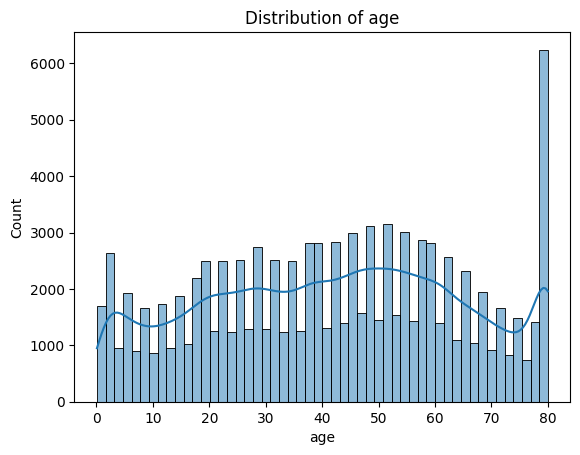

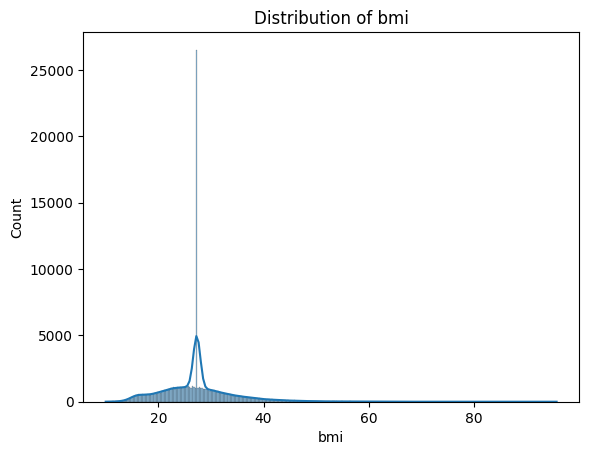

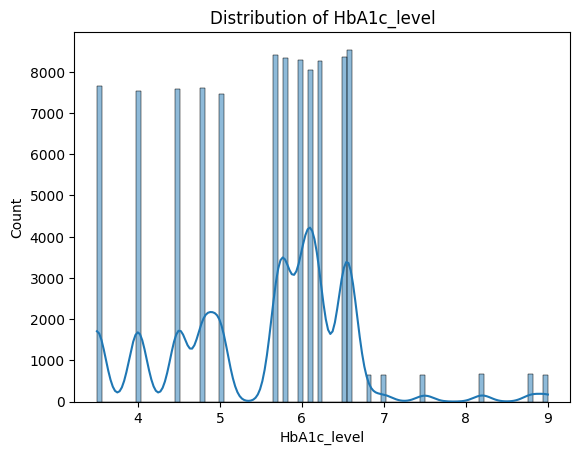

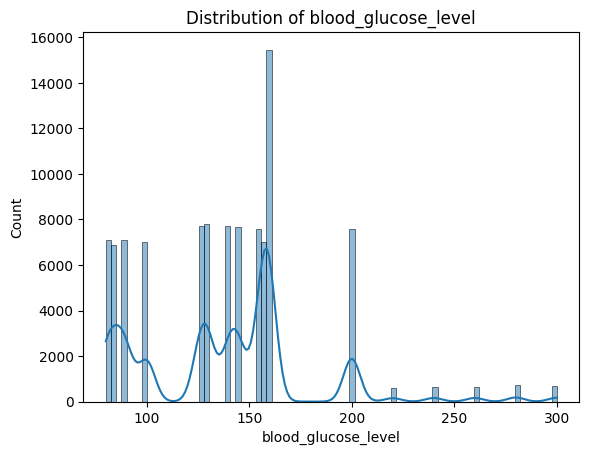

In [15]:
for col in numeric_features:
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

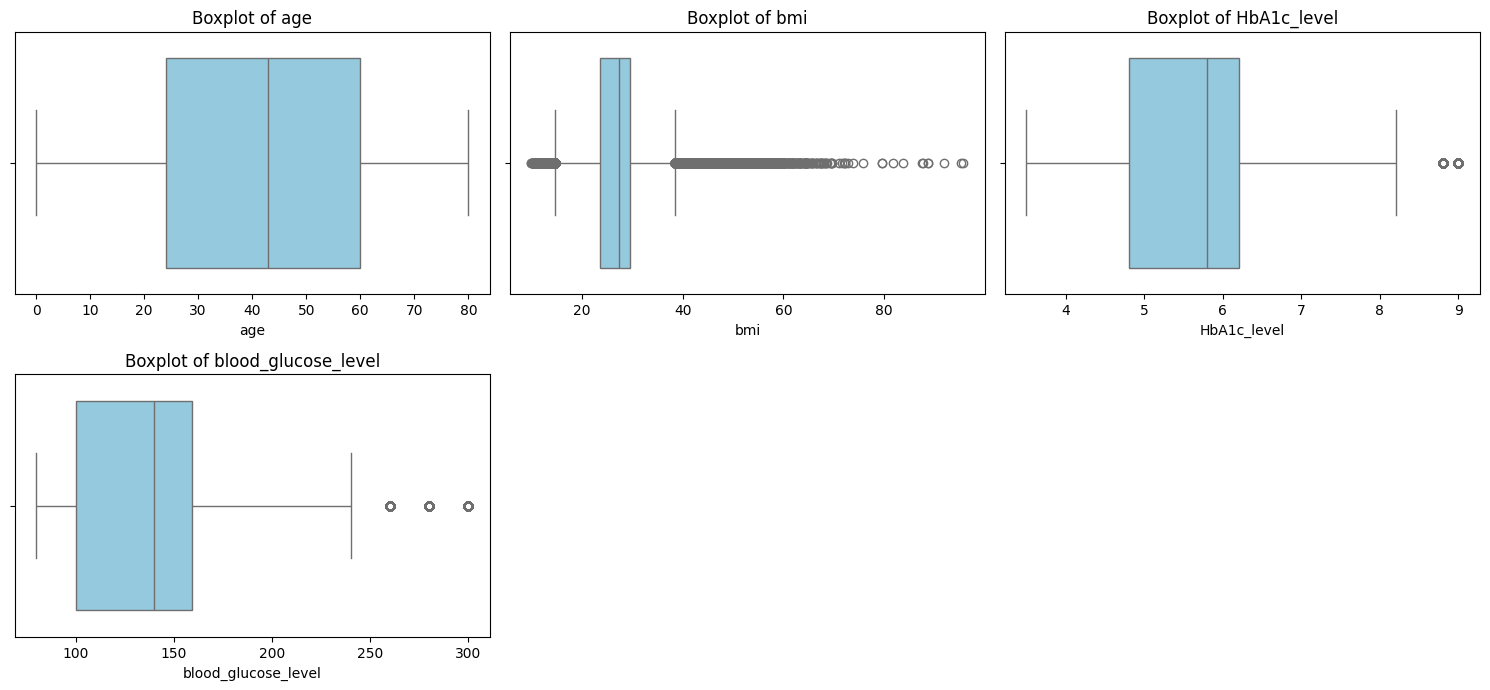

In [16]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)  
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

In [17]:
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.corr()['diabetes'].sort_values(ascending=False)

diabetes                       1.000000
blood_glucose_level            0.419587
HbA1c_level                    0.400696
age                            0.257999
bmi                            0.214377
hypertension                   0.197811
heart_disease                  0.171718
smoking_history_former         0.097901
gender                         0.037623
smoking_history_never          0.027248
smoking_history_ever           0.024088
smoking_history_not current    0.020831
smoking_history_unknown       -0.118953
Name: diabetes, dtype: float64

### Training

In [18]:
def evaluate_model(model, model_name, X_test, y_test, results_df=None):
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # ROC AUC (handle cases where predict_proba is not available)
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    else:
        roc_auc = None
    
    # Create results dictionary
    results = {
        'Model': model_name,
        'Accuracy': round(accuracy, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1 Score': round(f1, 4),
        'ROC AUC': round(roc_auc, 4) if roc_auc is not None else 'N/A'
    }
    
    # Create or append to DataFrame
    if results_df is None:
        results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])
    
    results_df = pd.concat([results_df, pd.DataFrame([results])], ignore_index=True)
    print(f"Model: {results['Model']}")   
    print(f"Accuracy: {results['Accuracy']}")
    print(f"Precision: {results['Precision']}")
    print(f"Recall: {results['Recall']}")
    print(f"F1 Score: {results['F1 Score']}")
    print(f"ROC AUC: {results['ROC AUC']}")

    return results_df

In [19]:
result_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])

In [20]:
X = df[numeric_features + categorical_features].copy()
y = df['diabetes'].astype(int).values

# Stratified split to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (79985, 8) Test shape: (19997, 8)


In [21]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ]
)

# Then proceed with your current SMOTE approach
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_processed, y_train)

In [22]:
preprocessor_one_hot_encoding = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ]
)

# Then proceed with your current SMOTE approach
X_train_processed_one_hot_encoding = preprocessor_one_hot_encoding.fit_transform(X_train)
X_test_processed_one_hot_encoding = preprocessor_one_hot_encoding.transform(X_test)

In [23]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train_res, y_train_res)
result_df = evaluate_model(lr, 'Logistic Regression Standard Scaled and Resampled', X_test_processed, y_test, result_df)

Model: Logistic Regression Standard Scaled and Resampled
Accuracy: 0.8882
Precision: 0.4246
Recall: 0.8859
F1 Score: 0.574
ROC AUC: 0.9626


In [24]:
result_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression Standard Scaled and Resampled,0.8882,0.4246,0.8859,0.574,0.9626


In [25]:
unscaled_unsampled_lr = LogisticRegression(random_state=42)
unscaled_unsampled_lr.fit(X_train_processed_one_hot_encoding, y_train)

result_df = evaluate_model(unscaled_unsampled_lr, 'Logistic Regression', X_test_processed_one_hot_encoding, y_test, result_df)

Model: Logistic Regression
Accuracy: 0.9134
Precision: 0.3841
Recall: 0.0312
F1 Score: 0.0577
ROC AUC: 0.7205


In [26]:
result_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression Standard Scaled and Resampled,0.8882,0.4246,0.8859,0.5740,0.9626
1,Logistic Regression,0.9134,0.3841,0.0312,0.0577,0.7205


In [27]:
from imblearn.pipeline import Pipeline as ImbPipeline

# Use imblearn's Pipeline instead of sklearn's
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42))
])

# Define parameter grid (note: some solver/penalty combinations may not work)
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear'],
    'classifier__max_iter': [1000]
}

# Perform grid search
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=3, 
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters: {'classifier__C': 0.1, 'classifier__max_iter': 1000, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best cross-validation score: 0.9619748305081464


In [28]:
best_params = grid_search.best_params_
best_params

{'classifier__C': 0.1,
 'classifier__max_iter': 1000,
 'classifier__penalty': 'l2',
 'classifier__solver': 'liblinear'}

In [29]:
grid_search.best_estimator_

,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [30]:
parameter_tuned_lr = grid_search.best_estimator_

In [32]:
result_df = evaluate_model(parameter_tuned_lr, 'Logistic Regression Parameter Tuned', X_test, y_test, result_df)

Model: Logistic Regression Parameter Tuned
Accuracy: 0.8882
Precision: 0.4245
Recall: 0.8865
F1 Score: 0.5741
ROC AUC: 0.9626


In [33]:
result_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression Standard Scaled and Resampled,0.8882,0.4246,0.8859,0.5740,0.9626
1,Logistic Regression,0.9134,0.3841,0.0312,0.0577,0.7205
2,Logistic Regression Parameter Tuned,0.8882,0.4245,0.8865,0.5741,0.9626


### DescisionTree

In [34]:
dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_train_res, y_train_res)

result_df = evaluate_model(dt, 'Decision Tree Classifier Standard Scaled and Resampled', X_test_processed, y_test, result_df)

Model: Decision Tree Classifier Standard Scaled and Resampled
Accuracy: 0.9473
Precision: 0.6713
Recall: 0.7459
F1 Score: 0.7066
ROC AUC: 0.8561


In [35]:
result_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression Standard Scaled and Resampled,0.8882,0.4246,0.8859,0.5740,0.9626
1,Logistic Regression,0.9134,0.3841,0.0312,0.0577,0.7205
2,Logistic Regression Parameter Tuned,0.8882,0.4245,0.8865,0.5741,0.9626
3,Decision Tree Classifier Standard Scaled and R...,0.9473,0.6713,0.7459,0.7066,0.8561


In [36]:
unscaled_unsampled_dt = DecisionTreeClassifier(random_state=42)

unscaled_unsampled_dt.fit(X_train_processed_one_hot_encoding, y_train)

result_df = evaluate_model(unscaled_unsampled_dt, 'Decision Tree Classifier', X_test_processed_one_hot_encoding, y_test, result_df)

Model: Decision Tree Classifier
Accuracy: 0.9148
Precision: 0.4118
Recall: 0.0041
F1 Score: 0.0082
ROC AUC: 0.7205


In [37]:
dt_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

dt_param_grid = {
    'classifier__criterion': ['gini'],
    'classifier__max_depth': [5, 10, 15],
    'classifier__min_samples_split': [5, 10],
    'classifier__min_samples_leaf': [2, 4],
    'classifier__max_features': ['sqrt'],
    'classifier__splitter': ['best']
}

dt_grid_search = GridSearchCV(
    dt_pipeline, 
    dt_param_grid, 
    cv=3, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

dt_grid_search.fit(X_train, y_train)

print("Best Decision Tree parameters:", dt_grid_search.best_params_)
print("Best Decision Tree cross-validation score:", dt_grid_search.best_score_)

best_dt_model = dt_grid_search.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Decision Tree parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 15, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__splitter': 'best'}
Best Decision Tree cross-validation score: 0.9222354286517226


In [38]:
result_df = evaluate_model(best_dt_model, 'Decision Tree Classifier Parameter Tuned', X_test, y_test, result_df)

Model: Decision Tree Classifier Parameter Tuned
Accuracy: 0.9236
Precision: 0.5333
Recall: 0.8112
F1 Score: 0.6435
ROC AUC: 0.9455


In [39]:
result_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression Standard Scaled and Resampled,0.8882,0.4246,0.8859,0.5740,0.9626
1,Logistic Regression,0.9134,0.3841,0.0312,0.0577,0.7205
2,Logistic Regression Parameter Tuned,0.8882,0.4245,0.8865,0.5741,0.9626
3,Decision Tree Classifier Standard Scaled and R...,0.9473,0.6713,0.7459,0.7066,0.8561
4,Decision Tree Classifier,0.9148,0.4118,0.0041,0.0082,0.7205
5,Decision Tree Classifier Parameter Tuned,0.9236,0.5333,0.8112,0.6435,0.9455


### RandomForest

In [40]:
rf = RandomForestClassifier(random_state=42)

rf.fit(X_train_res, y_train_res)

result_df = evaluate_model(rf, 'Random Forest Classifier Standard Scaled and Resampled', X_test_processed, y_test, result_df)

Model: Random Forest Classifier Standard Scaled and Resampled
Accuracy: 0.9598
Precision: 0.7765
Recall: 0.74
F1 Score: 0.7578
ROC AUC: 0.9675


In [41]:
unscaled_unsampled_rf = RandomForestClassifier(random_state=42)

unscaled_unsampled_rf.fit(X_train_processed_one_hot_encoding, y_train)

result_df = evaluate_model(unscaled_unsampled_rf, 'Random Forest Classifier', X_test_processed_one_hot_encoding, y_test, result_df)

Model: Random Forest Classifier
Accuracy: 0.9148
Precision: 0.4118
Recall: 0.0041
F1 Score: 0.0082
ROC AUC: 0.7205


In [42]:

rf_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

rf_param_grid = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [10, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1],
    'classifier__max_features': ['sqrt'],
    'classifier__criterion': ['gini']
}

rf_grid_search = GridSearchCV(
    rf_pipeline, 
    rf_param_grid, 
    cv=3, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

rf_grid_search.fit(X_train, y_train)

print("Best Random Forest parameters:", rf_grid_search.best_params_)
print("Best Random Forest cross-validation score:", rf_grid_search.best_score_)

best_rf_model = rf_grid_search.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Random Forest parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Best Random Forest cross-validation score: 0.9600550257766921


In [43]:
result_df = evaluate_model(best_rf_model, 'Random Forest Classifier Parameter Tuned', X_test, y_test, result_df)

Model: Random Forest Classifier Parameter Tuned
Accuracy: 0.9599
Precision: 0.7763
Recall: 0.7429
F1 Score: 0.7592
ROC AUC: 0.9705


### Gradient Boosting

In [44]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_res, y_train_res)

result_df = evaluate_model(gb, 'Gradient Boosting Classifier Standard Scaled and Resampled', X_test_processed, y_test, result_df)

Model: Gradient Boosting Classifier Standard Scaled and Resampled
Accuracy: 0.955
Precision: 0.7162
Recall: 0.7794
F1 Score: 0.7465
ROC AUC: 0.9765


In [45]:
unscaled_unsampled_gb = GradientBoostingClassifier(random_state=42)

unscaled_unsampled_gb.fit(X_train_processed_one_hot_encoding, y_train)

result_df = evaluate_model(unscaled_unsampled_gb, 'Gradient Boosting Classifier', X_test_processed_one_hot_encoding, y_test, result_df)

Model: Gradient Boosting Classifier
Accuracy: 0.9148
Precision: 0.4118
Recall: 0.0041
F1 Score: 0.0082
ROC AUC: 0.7206


In [46]:
result_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression Standard Scaled and Resampled,0.8882,0.4246,0.8859,0.5740,0.9626
1,Logistic Regression,0.9134,0.3841,0.0312,0.0577,0.7205
2,Logistic Regression Parameter Tuned,0.8882,0.4245,0.8865,0.5741,0.9626
3,Decision Tree Classifier Standard Scaled and R...,0.9473,0.6713,0.7459,0.7066,0.8561
4,Decision Tree Classifier,0.9148,0.4118,0.0041,0.0082,0.7205
5,Decision Tree Classifier Parameter Tuned,0.9236,0.5333,0.8112,0.6435,0.9455
6,Random Forest Classifier Standard Scaled and R...,0.9598,0.7765,0.7400,0.7578,0.9675
7,Random Forest Classifier,0.9148,0.4118,0.0041,0.0082,0.7205
8,Random Forest Classifier Parameter Tuned,0.9599,0.7763,0.7429,0.7592,0.9705
9,Gradient Boosting Classifier Standard Scaled a...,0.9550,0.7162,0.7794,0.7465,0.9765
